<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

## Chatbot: catégorisations et prévisions des réponses aux questions

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit de prévoir la réponse à une question à partir de son sujet. Seule la catégorie principale (1er niveau) est prédite mais nous pourrons essayer d'affiner par la suite. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision va être mise en oeuvre. Nous allons essayer différentes techniques d'échantillonnage comme le regroupement de plusieurs catégories en fonction de leur points communs ou selon leur taille puis nous essayerons de mettre en place un mélange de upsampling et de downsampling.
* Nous allons réduire l'échantillon réduit en le séparant en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

C:\Users\emma\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.


In [3]:
# Répertoire de travail
DATA_DIR = "C:\Users\emma\Documents\ecole\insa\projet chabot\INSA_wefight_data_clean.csv"

# Nom des fichiers
training_reduit_path = DATA_DIR 
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [4]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [5]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
data_all=pd.read_csv(training_reduit_path,sep=",",names=HEADER_TRAIN,nrows=nb_line)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
3090,"comment prévenir les maux de bouche,",#6-53_TRTEINS_Aphtes,59918dbae4b0feb28887a14b,wiki_cancer
4626,c'est quoi une chimio métastatique ?,#9-13_Informations_metastase,59632c41e4b0a226d067ca41,wiki_cancer
1823,Comment lutter contre la fatigue,#2-70_QVDP_Fatigue_Diminuer,59846299e4b03f0d14154cf5,wiki_cancer
2768,que veut dire drainage lymphatique,#6-39_TRTEINS_DrainageLymphodeme,598b50d6e4b03f0d3717ad2d,wiki_cancer
1805,l'hormonothérapie peut elle entrainer de la fa...,#2-65_QVDP_Fatigue_Hormono,59846078e4b03f0d14063fb7,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [6]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open("C:\Users\emma\Documents\ecole\insa\projet chabot\lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [7]:
# remarque
#'a b c'.split()
#str.split('a b c')
# both return ['a', 'b', 'c']

In [8]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [9]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [38]:
stopwords_perso= ["veut", "peut", "doit", "peux", "faire", "veux"]
## Fonction de setmming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
stopwords2 = list(set(stopwords).union(set(stopwords_perso)))

# Fonction clean générale
def clean_txt2(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords2)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

    # fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df2(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt2,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

 
#meta_df_clean=clean_df2(meta_df11)

In [39]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df2(data_valid)
data_train_clean = clean_df2(data_train)
#data_all_clean=clean_df(data_all) ne marche pas pourquoi ?

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 5 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [40]:
data_train_clean.head()

,Question,Intent,BlockId,Action
0,preven maux bouch,#6-53_TRTEINS_Aphtes,59918dbae4b0feb28887a14b,wiki_cancer
1,chimio metastat,#9-13_Informations_metastase,59632c41e4b0a226d067ca41,wiki_cancer
2,lutt fatigu,#2-70_QVDP_Fatigue_Diminuer,59846299e4b03f0d14154cf5,wiki_cancer
3,dir drainag lymphat,#6-39_TRTEINS_DrainageLymphodeme,598b50d6e4b03f0d3717ad2d,wiki_cancer
4,hormonotherap entrain fatigu,#2-65_QVDP_Fatigue_Hormono,59846078e4b03f0d14063fb7,wiki_cancer


## Nous allons concatener toutes les questions d'une même sous catégorie afin de n'avoir plus qu'une question par sous catégorie

In [41]:
intents = pd.Series(data_train_clean['Intent'])
A=intents.value_counts(sort=True)
list(A.index)

['#6-49_TRTEINS_Peau',
 '#6-97_TRTEINS_Nausees_Vomissements',
 '#6-92_TRTEINS_Diarrhee',
 '#2-130_QVDP_Alimentation',
 '#6-53_TRTEINS_Aphtes',
 '#6-90_TRTEINS_Mauvais_Gout',
 '#2-36_QVDP_Alopecie_Pourquoi',
 '#6-98_TRTEINS_EI_Frequents',
 '#9-2_Informations_cancer',
 '#6-60_TRTEINS_PAC',
 '#6-18_TRTEINS_Radiotherapie',
 '#6-57_TRTEINS_Yeux_Secs',
 'conversation_rappel_rendezvous',
 '#2-45_QVDP_Alopecie_Perruque',
 '#2-55_QVDP_Douleur',
 '#6-1_TRTEINS_Chimiotherapie',
 '#2-64-0_QVDP_Fatigue',
 '#6-96_TRTEINS_Perte_Poids',
 '#6-24_TRTEINS_hormonotherapie',
 '#2-96_QVDP_Social_Priseencharge',
 '#6-58_TRTEINS_Bouche_Seche',
 '#2-120_QVDP_Sexualite',
 '#6-34_TRTEINS_Lymphoedeme',
 '#2-107_QVDP_Grossesse',
 '#2-128_QVDP_Sexualite_Couple',
 '#6-73_TRTEINS_Chirurgie_Mastectomie',
 '#6-93_TRTEINS_Mauvaise_Haleine',
 '#2-41_QVDP_Alopecie_Diminuer',
 '#5-37_Soutien_Psychologique',
 '#2-125_QVDP_Sexualite_Reconstruction',
 '#9-53_Informations_depistagesein',
 '#2-73_QVDP_Sport',
 '#6-31_TRTEINS_Ef

In [42]:
new_data = []
for k,v in data_train_clean.groupby("Intent"):
    all_string = " ".join(v["Question"].values)
    new_row = [all_string, k]
    new_data.append(new_row)
new_df = pd.DataFrame(new_data, columns=["Question","Intent"])

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

stop_words = nltk.corpus.stopwords.words('french')
question = new_df["Question"] #on va travailler que sur la colonne des questions
vec = TfidfVectorizer(
            min_df = 1,
            stop_words =stop_words,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=True, #tf avec idf
            ngram_range=(1,2)) #bi-grams
tfidf =  vec.fit_transform(question)

In [44]:
mot_disc2=dict(sorted(zip(vec.get_feature_names(),vec.idf_), key = lambda x: x[1]))

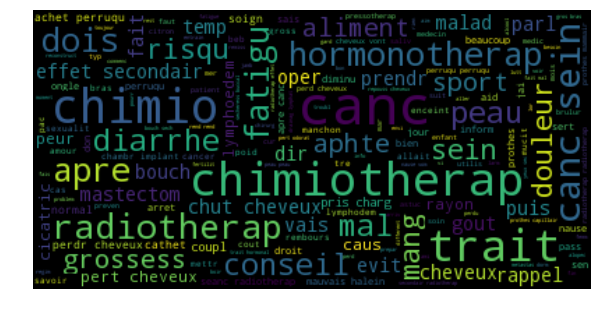

In [46]:
from os import path
from wordcloud import WordCloud
description = new_df["Question"]
description.to_csv('Question.csv', sep = ',')
text = open("C:\Users\emma\Documents\ecole\insa\projet chabot\Question.csv").read()
frequencies= mot_disc2 #dict word-freq
# Generate a word cloud image
wordcloud = WordCloud().generate_from_frequencies(frequencies)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()